In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import cv
from catboost import datasets, metrics
from sklearn import metrics
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [2]:
data = pd.read_csv('gepatit.csv', sep=',')
data

,group,toxicant,time,Casp7,Chek,Gclc,Gstm1,Gstp1,Gstt1,Hmox,Nfe2l2,Nqo1,Ripk,Sod1,Apoptoz
0,0,1,1,0.95,1.32,-1.25,0.73,2.28,-1.21,1.29,0.51,-0.93,0.500,-0.90,2.375
1,0,1,1,0.04,0.52,-0.61,0.24,-0.11,1.76,-0.18,-0.92,-0.97,0.650,0.74,3.287
2,0,1,1,-0.73,-0.87,-0.20,-0.39,-1.04,-0.11,0.30,0.31,-0.56,-0.320,0.43,2.347
3,0,1,1,0.87,0.42,0.10,0.80,-0.33,-0.98,0.23,1.05,-0.71,0.340,0.01,2.316
4,0,1,1,-0.29,0.03,1.87,-0.40,1.09,-0.36,-1.39,0.28,0.21,1.330,-0.43,2.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,4,3,2,-0.97,-0.40,-0.27,-1.18,-2.74,-1.75,-1.33,-0.99,0.02,-1.860,-2.96,1.341
206,4,3,2,-0.46,0.49,1.50,1.59,3.18,0.68,0.93,0.43,1.07,-0.958,-1.86,1.818
207,4,3,2,0.64,0.32,3.60,-1.13,-1.49,-1.89,-1.07,-0.95,-0.27,-1.000,-2.79,1.826
208,4,3,2,-1.08,0.03,0.01,-0.93,-1.45,0.68,-1.37,-1.02,0.55,-1.300,-3.29,2.046


In [3]:
X = data.loc[:,'Casp7':'Sod1']
y = data['toxicant']
y[y==1] = 0
y[y==2] = 1
y[y==3] = 2
# y[y==2] = 0
# y[y==3] = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)



C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\1948416196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==1] = 0
C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\1948416196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==2] = 1
C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\1948416196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==3] = 2


In [4]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

In [5]:
xgb_param_grid = {
     'max_depth': [4],
     'learning_rate': [ 0.02],
     'n_estimators': [300], 
     'min_child_weight': [2],
     'scale_pos_weight': [0.2],
     'subsample': [0.8],  
     'colsample_bytree': [0.5],
     'colsample_bylevel': [0.8], 
     'reg_alpha': [0.11],  
     'reg_lambda': [0.05], 
     'max_delta_step': [1],    
     'gamma': [0]
}

In [13]:
%%time
# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=0)

# Find the best hyperparameters
xgb_opt = tune_hyperparameters(xgb, xgb_param_grid, X_train, y_train)


[16:43:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Best hyperparameters:
 {'colsample_bylevel': 0.8, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'reg_alpha': 0.11, 'reg_lambda': 0.05, 'scale_pos_weight': 0.2, 'subsample': 0.8}
CPU times: total: 625 ms
Wall time: 870 ms


In [33]:
model_result = pd.DataFrame({'Name': [],
                             'toxic' : [],
                             'AUC': [],
                             'error': [],
                             })

<Figure size 432x288 with 0 Axes>

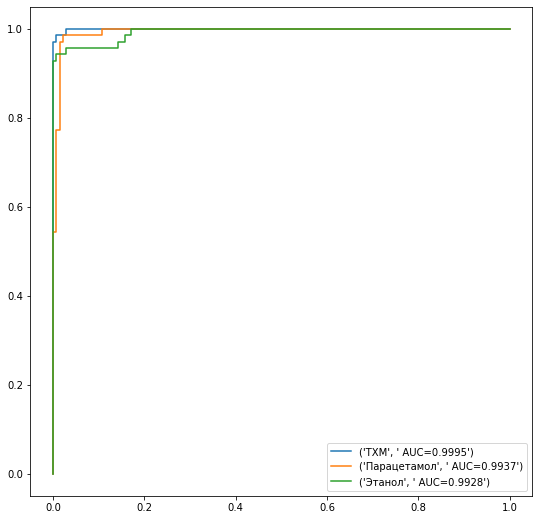

In [34]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = xgb_opt.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])

y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
error = 0
for i in range(len(y1)):
    if y1[i] != round(y_pred1[i]):
        error += 1
  
    
model_result.loc[ len(model_result.index)] = ['XGBoost', 'ТХМ', auc, error]


fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
error = 0
for i in range(len(y2)):
    if y2[i] != round(y_pred2[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['XGBoost', 'Парацетамол', auc, error]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
error = 0
for i in range(len(y3)):
    if y3[i] != round(y_pred3[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['XGBoost', 'Этанол', auc, error];

In [35]:
y_pred1[1]

0.58790195

In [36]:
%%time
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.01, n_estimators=1000)
clf.fit(X_train, y_train)

CPU times: total: 1.12 s
Wall time: 646 ms


LGBMClassifier(learning_rate=0.01, n_estimators=1000)

<Figure size 432x288 with 0 Axes>

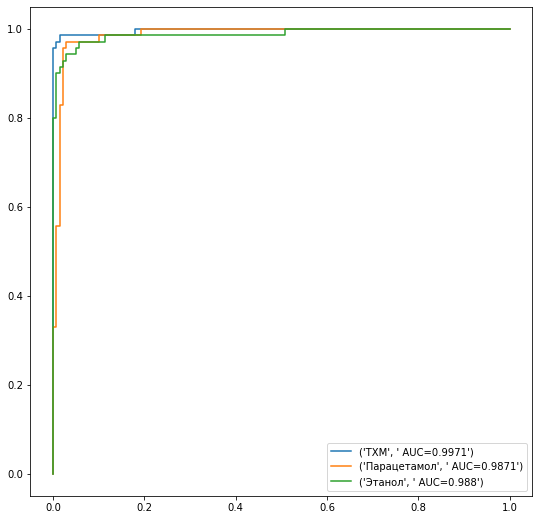

In [37]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = clf.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])

y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
error = 0
for i in range(len(y1)):
    if y1[i] != round(y_pred1[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['LightGBM', 'ТХМ', auc, error]

fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
error = 0
for i in range(len(y2)):
    if y2[i] != round(y_pred2[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['LightGBM', 'Парацетамол', auc, error]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
error = 0
for i in range(len(y3)):
    if y3[i] != round(y_pred3[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['LightGBM', 'Этанол', auc, error];

In [38]:
cat_features = []
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=2000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6,
    custom_loss=['AUC', 'Accuracy']
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_test, y_test),
    plot=True
)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<Figure size 432x288 with 0 Axes>

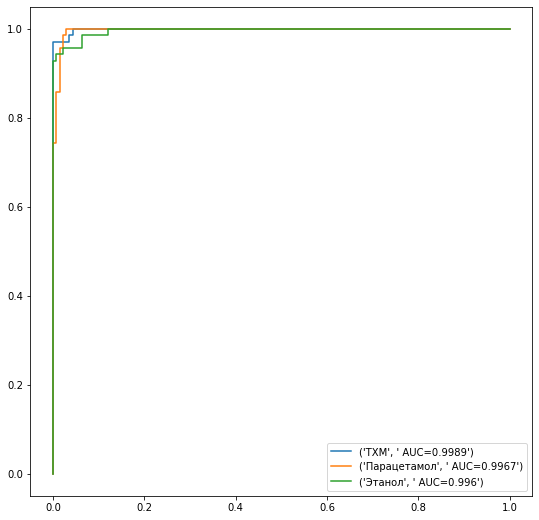

In [39]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = tunned_model.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])


y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
error = 0
for i in range(len(y1)):
    if y1[i] != round(y_pred1[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['CatBoost', 'ТХМ', auc, error]

fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
error = 0
for i in range(len(y2)):
    if y2[i] != round(y_pred2[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['CatBoost', 'Парацетамол', auc, error]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
error = 0
for i in range(len(y3)):
    if y3[i] != round(y_pred3[i]):
        error += 1
model_result.loc[ len(model_result.index)] = ['CatBoost', 'Этанол', auc, error];

In [40]:
model_result

,Name,toxic,AUC,error
0,XGBoost,ТХМ,0.9995,3
1,XGBoost,Парацетамол,0.9937,5
2,XGBoost,Этанол,0.9928,6
3,LightGBM,ТХМ,0.9971,3
4,LightGBM,Парацетамол,0.9871,7
5,LightGBM,Этанол,0.9880,8
6,CatBoost,ТХМ,0.9989,2
7,CatBoost,Парацетамол,0.9967,4
8,CatBoost,Этанол,0.9960,6


In [41]:
y4=y
y4[y4 == 2] = 3
y4[y4 == 1] = 3
y4[y4 == 0] = 1
y4[y4 == 3] = 0
y4.unique()

C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\3379802457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y4[y4 == 2] = 3
C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\3379802457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y4[y4 == 1] = 3
C:\Users\KarimovDO\AppData\Local\Temp\ipykernel_15404\3379802457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y4[y4 == 0] = 1
C:\Users\KarimovDO\AppData\Local\Temp\ip

array([1, 0], dtype=int64)

In [42]:
model2 = CatBoostClassifier(
    random_seed=63,
    iterations=2000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6,
    custom_loss=['AUC', 'Accuracy']
)
model2.fit(
    X, y4,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6649753	total: 4.01ms	remaining: 8.02s
50:	learn: 0.1892929	total: 169ms	remaining: 6.46s
100:	learn: 0.1008830	total: 344ms	remaining: 6.47s
150:	learn: 0.0623225	total: 509ms	remaining: 6.24s
200:	learn: 0.0400961	total: 670ms	remaining: 5.99s
250:	learn: 0.0260741	total: 827ms	remaining: 5.76s
300:	learn: 0.0183282	total: 1.01s	remaining: 5.7s
350:	learn: 0.0138688	total: 1.19s	remaining: 5.59s
400:	learn: 0.0112379	total: 1.35s	remaining: 5.39s
450:	learn: 0.0091971	total: 1.5s	remaining: 5.15s
500:	learn: 0.0078609	total: 1.65s	remaining: 4.95s
550:	learn: 0.0068738	total: 1.81s	remaining: 4.77s
600:	learn: 0.0060668	total: 1.98s	remaining: 4.6s
650:	learn: 0.0054575	total: 2.13s	remaining: 4.41s
700:	learn: 0.0049380	total: 2.28s	remaining: 4.23s
750:	learn: 0.0045208	total: 2.43s	remaining: 4.04s
800:	learn: 0.0041895	total: 2.6s	remaining: 3.88s
850:	learn: 0.0038609	total: 2.75s	remaining: 3.72s
900:	learn: 0.0035871	total: 2.92s	remaining: 3.56s
950:	learn: 0.0033

In [43]:
pool1 = Pool(data=X, label=y4, cat_features=cat_features)
shap_info = model2.get_feature_importance(data=pool1, type='ShapValues', verbose=10000)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
print(shap_values.shape)

Processing trees...
128/2000 trees processed	passed time: 243ms	remaining time: 3.56s
2000/2000 trees processed	passed time: 2.1s	remaining time: 0us
Processing documents...
128/210 documents processed	passed time: 20.9ms	remaining time: 13.4ms
210/210 documents processed	passed time: 40.3ms	remaining time: 0us
(210, 11)


In [44]:
X.iloc[0:1]

,Casp7,Chek,Gclc,Gstm1,Gstp1,Gstt1,Hmox,Nfe2l2,Nqo1,Ripk,Sod1
0,0.95,1.32,-1.25,0.73,2.28,-1.21,1.29,0.51,-0.93,0.5,-0.9


In [45]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model2.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model2.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9964
Formula raw prediction = 5.6327




In [46]:
import shap
i = 20
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [47]:
i = 50
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [48]:
i = 100
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [52]:
i = 200
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [50]:
explainer = shap.TreeExplainer(model2)
shap_values=explainer.shap_values(Pool(X, y, cat_features=cat_features))

In [51]:
shap.force_plot(explainer.expected_value, shap_values, X)

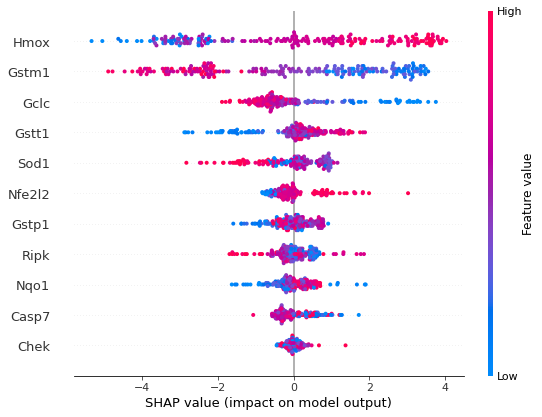

In [53]:
tree_explainer = shap.TreeExplainer(model2)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)